In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib widget

In [8]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from os.path import join
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.h3_utils import get_hexagons_for_edges
from src.tools.osmnx_utils import get_place_dir_name

In [6]:
tqdm.pandas()

In [ ]:
edges.shp = gdp.read_file()

In [17]:
edges.columns

Index(['osmid', 'h3_id', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2',
       'lanes_3', 'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7',
       'highway_living_street', 'highway_motorway', 'highway_motorway_link',
       'highway_primary', 'highway_primary_link', 'highway_residential',
       'highway_secondary', 'highway_secondary_link', 'highway_tertiary',
       'highway_tertiary_link', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified', 'maxspeed_10', 'maxspeed_100', 'maxspeed_110',
       'maxspeed_120', 'maxspeed_15', 'maxspeed_20', 'maxspeed_30',
       'maxspeed_40', 'maxspeed_50', 'maxspeed_60', 'maxspeed_70',
       'maxspeed_80', 'maxspeed_90', 'bridge_viaduct', 'bridge_yes',
       'access_delivery', 'access_destination', 'access_no',
       'access_permissive', 'access_yes', 'junction_roundabout', 'width_1.5',
       'width_2', 'width_2.5', 'width_3', 'width_4', 'width_4.5', 'width_6',
       'tunnel_building_passage', 'tunnel_yes', 'geometry'],
      dtype='

In [19]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 9
buffered = True
edges = gpd.read_file(join(GENERATED_DATA_DIR, place_dir_name, f"edges_drive_{resolution}{'_buffered' if buffered else ''}.geojson"), driver="GeoJSON")
edges

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry
0,0,"[ 24707867, 656793686 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083..."
1,1,"[ 656794402, 28458110 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083..."
2,2,"[ 301726798, 189513998, 301726791 ]",891e2040b07ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
3,2,"[ 301726798, 189513998, 301726791 ]",891e2040b03ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
4,3,28458112,891e2040b03ffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04960 51.08289, 17.04957 51.082..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14669,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",891e2040c6fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
14670,9679,858291159,891e2040c67ffff,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
14671,9680,875668659,891e204e093ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
14672,9681,"[ 923192968, 923192971 ]",891e20462c3ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."


In [21]:
hex_feautres = edges.groupby(by="h3_id").sum()
hex_feautres

,id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,25231,5,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
891e2040013ffff,37655,4,2,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
891e2040017ffff,92657,8,4,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2040023ffff,13434,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2040027ffff,54702,8,5,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,54369,10,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b73ffff,30091,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b77ffff,76011,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

v = TfidfTransformer()
x = v.fit_transform(hex_feautres)
hex_features_tfidf = pd.DataFrame(x.toarray(), index=hex_feautres.index, columns=hex_feautres.columns)
hex_features_tfidf

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
hex_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,0.470573,0.000000,0.000000,0.301658,0.212162,0.0,0.0,0.0,0.0,0.435521,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470721,0.0
891e2040013ffff,0.207108,0.196286,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.479202,...,0.455064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2040017ffff,0.450572,0.427027,0.000000,0.180523,0.126965,0.0,0.0,0.0,0.0,0.390946,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2040023ffff,0.523837,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2040027ffff,0.312134,0.369779,0.101018,0.250114,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,0.638172,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2055b73ffff,0.641758,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2055b77ffff,0.641758,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
import hdbscan
import plotly.express as px
import umap

In [ ]:
mapper = umap.UMAP(n_neighbors=5, metric="euclidean").fit(hex_features_tfidf.values)
embedding = mapper.transform(hex_features_tfidf.values)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30, metric="euclidean")
embedding_df = pd.DataFrame(embedding, columns=["x", "y"])

# cluster_labels = clusterer.fit_predict(hex_features_tfidf)
cluster_labels = clusterer.fit_predict(embedding_df)

embedding_df["cluster"] = cluster_labels
embedding_df["cluster"] = embedding_df["cluster"].astype("category")
fig = px.scatter(embedding_df, x="x", y="y", color="cluster", width=800, height=700)
fig.show()

<AxesSubplot:ylabel='distance'>

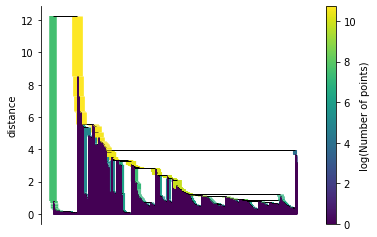

In [ ]:
clusterer.single_linkage_tree_.plot()

In [ ]:
embedding_df.index = hex_feautres.index

In [ ]:
hex_features = hex_feautres.join(embedding_df)

In [ ]:
h3_gdf = h3_gdf.rename(columns={"id": "hex_id"}).set_index("hex_id")

KeyError: "None of ['hex_id'] are in the columns"

In [ ]:
hex_gdf = h3_gdf.join(hex_features)

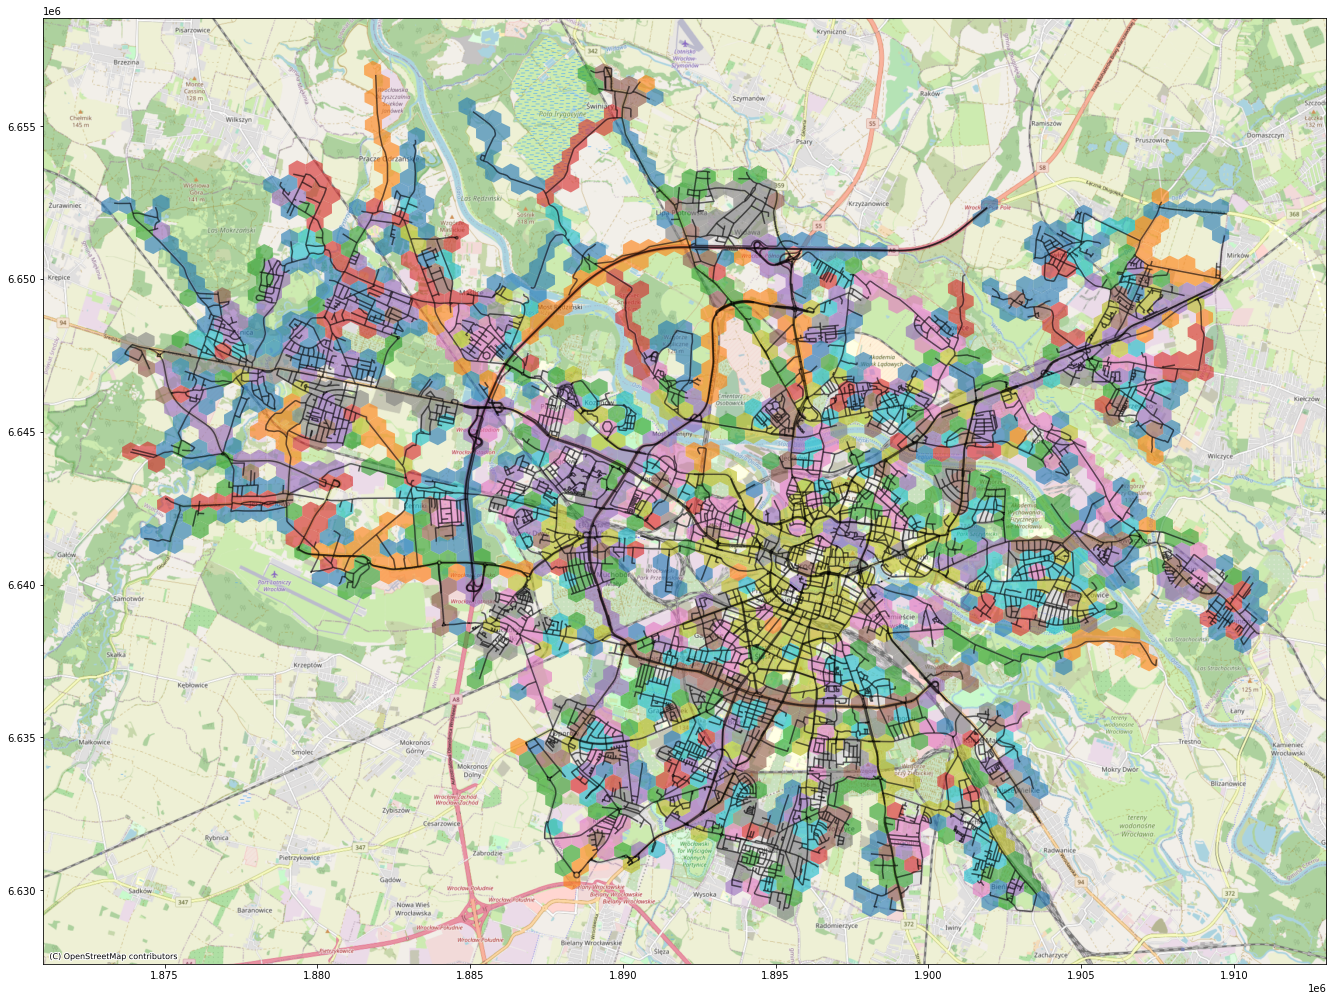

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
fig, ax = plt.subplots(1, 1, figsize=(23,18))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
hex_gdf[hex_gdf["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
edges.to_crs(epsg=3857).plot(ax=ax, color="black", alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [ ]:
hex_group_cluster = hex_features_tfidf.join(embedding_df).groupby(by="cluster")

In [ ]:
hex_agg = hex_group_cluster.mean().reset_index()
hex_agg

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,x,y
0,-1,0.348639,0.172071,0.062869,0.232323,0.093675,0.035717,0.012389,0.001004,0.002347,...,0.0,0.0,0.0,0.0,0.009761,0.009466,0.003008,0.000000,5.190566,2.931538
1,0,0.641509,0.001768,0.000000,0.001530,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,27.225769,5.840323
2,1,0.248476,0.000000,0.000000,0.398210,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,5.922316,-13.986572
3,2,0.424874,0.038576,0.000000,0.040810,0.045878,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,18.218220,-2.357623
4,3,0.312671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,9.169794,-5.835208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,95,0.496430,0.056999,0.020109,0.375363,0.014860,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.016436,0.043122,2.839219,2.619344
97,96,0.440703,0.024953,0.014017,0.481990,0.028505,0.036427,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.025887,3.284373,1.730235
98,97,0.485989,0.019832,0.000000,0.390873,0.009500,0.024281,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,3.022166,2.030056
99,98,0.415775,0.088370,0.032665,0.053567,0.019210,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.018363,0.003273,2.167778,5.604768


In [ ]:
hex_agg.columns

Index(['cluster', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2', 'lanes_3',
       'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7', 'highway_living_street',
       'highway_motorway', 'highway_motorway_link', 'highway_primary',
       'highway_primary_link', 'highway_residential', 'highway_secondary',
       'highway_secondary_link', 'highway_tertiary', 'highway_tertiary_link',
       'highway_trunk', 'highway_trunk_link', 'highway_unclassified',
       'maxspeed_10', 'maxspeed_100', 'maxspeed_110', 'maxspeed_120',
       'maxspeed_15', 'maxspeed_20', 'maxspeed_30', 'maxspeed_40',
       'maxspeed_50', 'maxspeed_60', 'maxspeed_70', 'maxspeed_80',
       'maxspeed_90', 'bridge_viaduct', 'bridge_yes', 'access_delivery',
       'access_destination', 'access_no', 'access_permissive', 'access_yes',
       'junction_roundabout', 'width_1.5', 'width_2', 'width_2.5', 'width_3',
       'width_4', 'width_4.5', 'width_6', 'tunnel_building_passage',
       'tunnel_yes', 'x', 'y'],
      dtype='object')

In [ ]:
fig = px.bar(hex_agg, x="cluster", y=list(filter(lambda x: "bridge" in x, hex_agg.columns)), barmode="group", width=1300)
fig.show()